In [1]:
import torch
import torch.nn as nn
import torchvision.models as models
import torchvision.transforms as transforms
from torch.autograd import Variable
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

In [2]:
class FeatureVector(object):
    def __init__(self):
        self.model = models.resnet18(pretrained=True)
        self.model.eval()
        self.layer = self.model._modules.get("avgpool")
        self.cos = nn.CosineSimilarity(dim=1, eps=1e-6)
        self.transform_pipeline = transforms.Compose([transforms.Resize((224, 224)),
                                                      transforms.ToTensor(),
                                                      transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                                           std=[0.229, 0.224, 0.225])])
        
    def get_vector(self, img):
        t_img = Variable(self.transform_pipeline(img)).unsqueeze(0)
        feat_vec = torch.zeros(512)

        def copy_data(m, i, o):
            feat_vec.copy_(o.data.squeeze())

        h = self.layer.register_forward_hook(copy_data)
        self.model(t_img)
        h.remove()

        return feat_vec
    
    def similarity(self, a, b):
        return self.cos(a.unsqueeze(0), b.unsqueeze(0))

In [3]:
feat_vec = FeatureVector()

In [4]:
dog1 = Image.open('./images/dog1.jpg')
dog2 = Image.open('./images/dog2.jpg')
dog3 = Image.open('./images/dog3.jpg')
cat1 = Image.open('./images/cat1.jpg')
cat2 = Image.open('./images/cat2.jpg')
person1 = Image.open('./images/person1.jpg')
person2 = Image.open('./images/person2.jpg')

In [5]:
def compare(a, b):
    plt.figure()
    plt.subplot(1, 2, 1)
    plt.imshow(a)
    plt.subplot(1, 2, 2)
    plt.imshow(b)
    a_v = feat_vec.get_vector(a)
    b_v = feat_vec.get_vector(b)
    print('Similarity: {}'.format(feat_vec.similarity(a_v, b_v)))

Similarity: tensor([0.7978])


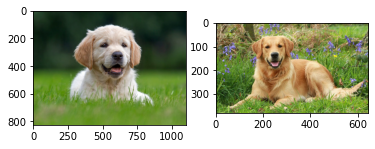

In [6]:
compare(dog1, dog2)

Similarity: tensor([0.5898])


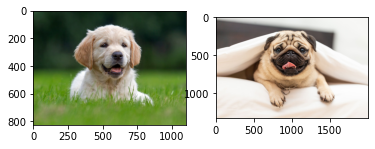

In [7]:
compare(dog1, dog3)

Similarity: tensor([0.7828])


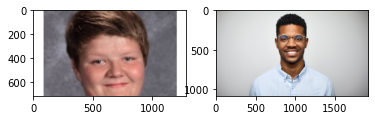

In [8]:
compare(person1, person2)

In [9]:
"""
ResNet18 512
Xception 2048
ShuffleNetV2 1000?
MobileNetV2 1000?

Using TNSE
Using PCA
Adding AvgPooling layer? (No training required)
https://tech.zegami.com/comparing-pre-trained-deep-learning-models-for-feature-extraction-c617da54641
"""

'\nResNet18 512\nXception 2048\nShuffleNetV2 1000?\nMobileNetV2 1000?\n\nUsing TNSE\nUsing PCA\nAdding AvgPooling layer? (No training required)\nhttps://tech.zegami.com/comparing-pre-trained-deep-learning-models-for-feature-extraction-c617da54641\n'

In [23]:
from milvus import Milvus, IndexType, MetricType, Status

# Milvus server IP address and port.
# You may need to change _HOST and _PORT accordingly.
_HOST = 'milvus'
_PORT = '19530'  # default value
# _PORT = '19121'  # default http value

# Vector parameters
_DIM = 512  # dimension of vector

_INDEX_FILE_SIZE = 32  # max file size of stored index



milvus = Milvus(_HOST, _PORT, pool_size=10)

# Create collection demo_collection if it dosen't exist.
collection_name = 'resnet18_simple'

status, ok = milvus.has_collection(collection_name)
if not ok:
    param = {
        'collection_name': collection_name,
        'dimension': _DIM,
        'index_file_size': _INDEX_FILE_SIZE,  # optional
        'metric_type': MetricType.L2  # optional
    }

    print(milvus.create_collection(param))

Status(code=0, message='Create collection successfully!')


In [25]:
# Show collections in Milvus server
# _, collections = milvus.list_collections()
# print(collections)
# Describe demo_collection
_, collection = milvus.get_collection_info(collection_name)
print(collection)

CollectionSchema(collection_name='resnet18_simple', dimension=512, index_file_size=32, metric_type=<MetricType: L2>)


In [26]:
images = [
    dog1,
    dog2,
    dog3,
    cat1,
    cat2,
    person1,
    person2
]

# 10000 vectors with 128 dimension
# element per dimension is float32 type
# vectors should be a 2-D array
vectors = [feat_vec.get_vector(i).tolist() for i in images]


# Insert vectors into demo_collection, return status and vectors id list
status, ids = milvus.insert(collection_name=collection_name, records=vectors)
if not status.OK():
    print("Insert failed: {}".format(status))
else: print(ids)

[1591756175340907000, 1591756175340907001, 1591756175340907002, 1591756175340907003, 1591756175340907004, 1591756175340907005, 1591756175340907006]


In [30]:
lookup = {}
for ID, img in zip(ids, images):
    lookup[ID] = img

for k in lookup:
    print(k, lookup[k])

1591756175340907000 <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1100x825 at 0x7F2163489950>
1591756175340907001 <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=645x380 at 0x7F2160BBCE10>
1591756175340907002 <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=2000x1333 at 0x7F2160BC2C10>
1591756175340907003 <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x400 at 0x7F2160BC2D10>
1591756175340907004 <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=2800x1575 at 0x7F2160BC2E10>
1591756175340907005 <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1280x720 at 0x7F2160BCEB90>
1591756175340907006 <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1920x1080 at 0x7F2160BCEC90>


In [31]:
# Flush collection  inserted data to disk.
milvus.flush([collection_name])

# Get demo_collection row count
status, result = milvus.count_entities(collection_name)
print(result)
# present collection statistics info
_, info = milvus.get_collection_stats(collection_name)
print(info)

# Obtain raw vectors by providing vector ids
# status, result_vectors = milvus.get_entity_by_id(collection_name, ids[0])

7
{'partitions': [{'row_count': 7, 'segments': [{'data_size': 14392, 'index_name': 'IDMAP', 'name': '1591756175344973000', 'row_count': 7}], 'tag': '_default'}], 'row_count': 7}


In [32]:
# create index of vectors, search more rapidly
index_param = {
    'nlist': 2048
}

# Create ivflat index in demo_collection
# You can search vectors without creating index. however, Creating index help to
# search faster
print("Creating index: {}".format(index_param))
status = milvus.create_index(collection_name, IndexType.IVF_FLAT, index_param)

# describe index, get information of index
status, index = milvus.get_index_info(collection_name)
print(index)

Creating index: {'nlist': 2048}
(collection_name='resnet18_simple', index_type=<IndexType: IVFLAT>, params={'nlist': 2048})


In [34]:
# execute vector similarity search
search_param = {
    "nprobe": 16
}

print("Searching ... ")

param = {
    'collection_name': collection_name,
    'query_records': [vectors[0]],
    'top_k': 10,
    'params': search_param,
}

status, results = milvus.search(**param)
if status.OK():
    print(results)
else:
    print("Search failed. ", status)

Searching ... 
[
[
(id:1591756175340907000, distance:0.0),
(id:1591756175340907001, distance:242.29891967773438),
(id:1591756175340907002, distance:483.3052978515625),
(id:1591756175340907005, distance:484.425537109375),
(id:1591756175340907006, distance:511.57611083984375),
(id:1591756175340907003, distance:667.3349609375),
(id:1591756175340907004, distance:676.9684448242188)
]
]


Distance: 0.0
Distance: 242.29891967773438
Distance: 483.3052978515625
Distance: 484.425537109375
Distance: 511.57611083984375
Distance: 667.3349609375
Distance: 676.9684448242188


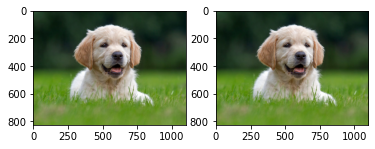

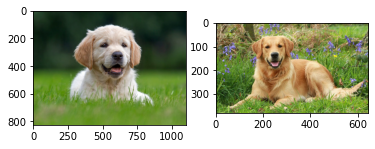

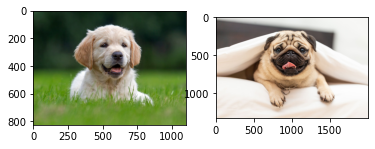

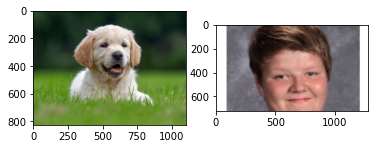

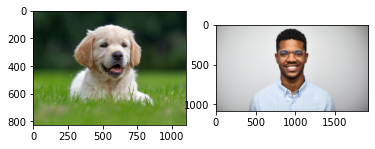

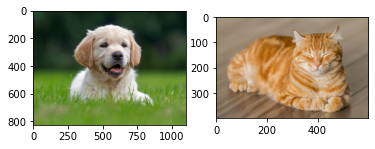

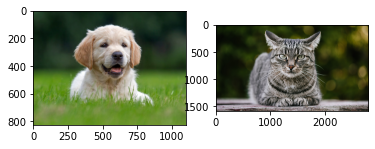

In [35]:
for neighbors in results:
    for n in neighbors:
        plt.figure()
        plt.subplot(1, 2, 1)
        plt.imshow(images[0])
        plt.subplot(1, 2, 2)
        plt.imshow(lookup[n.id])
        print('Distance: {}'.format(n.distance))

In [36]:
# Delete demo_collection
milvus.drop_collection(collection_name)

Status(code=0, message='Delete collection successfully!')